# Projekt zaliczeniowy
## Temat: 
Klasyfikacja sztućców za pomocą metody k-średnich
## Autor:
Klara Dargacz

### Import pakietów:

In [36]:
from numpy.lib.function_base import meshgrid
from skimage import (io, color, morphology, filters, data, exposure, segmentation, measure)
from skimage.segmentation import (morphological_chan_vese,
                                  morphological_geodesic_active_contour,
                                  inverse_gaussian_gradient,
                                  checkerboard_level_set)
from matplotlib import pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from sklearn.datasets import load_digits
import plotly
import plotly.express as px
import plotly.graph_objects as go
from skimage import data, filters, measure, morphology
import time
from numpy import arange
from numpy import meshgrid
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.preprocessing import StandardScaler

In [2]:
def plot(img, is_color=False):
    plt.figure(figsize=(8,8))
    if is_color:
        plt.imshow(img)
    else:
        plt.imshow(img, cmap = plt.cm.gray)
        
def plot_subplots(img1, img2):
    plt.figure(figsize=(12,12))
    plt.subplot(1,2,1)
    plt.imshow(img1, cmap = plt.cm.gray)
    plt.subplot(1,2,2)
    plt.imshow(img2, cmap = plt.cm.gray)
    plt.show()

### Załadowanie zdjęcia

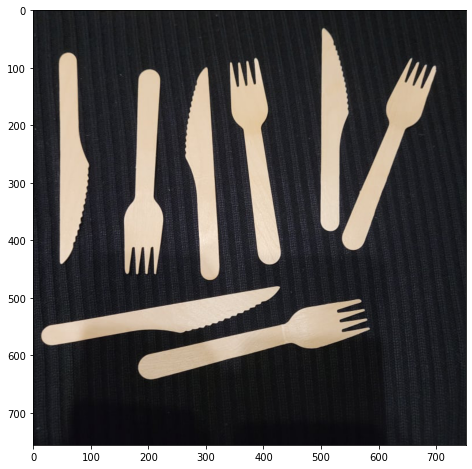

In [3]:
img = io.imread('papierowy2.jpg')
plot(img, True)

### Obrobienie zdjęcia

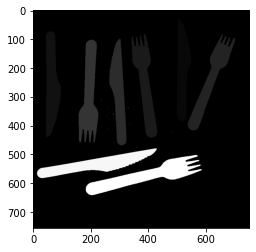

In [4]:
img_gray = color.rgb2gray(img)

img_equalized = exposure.equalize_adapthist(img_gray)
img_equalized = (img_equalized*255).astype('uint8')

img_filtered = filters.rank.mean(img_equalized, np.ones([1,1]))

threshold = filters.threshold_otsu(img_filtered)
img_bin = img_filtered > threshold

img_cleared_borders = segmentation.clear_border(img_bin)

img_opened = morphology.binary_opening(img_cleared_borders, np.ones([1,1]))

img_preprocessed = morphology.binary_closing(img_opened, np.ones([5,5]))

img_labeled = measure.label(img_preprocessed, connectivity=2)


plt.imshow(img_labeled, cmap = plt.cm.gray)


Wyodrębnienie cech:

In [5]:
regionprops = measure.regionprops(img_labeled)
indeksy_obiektow = []
for i in range (len(regionprops)):
  if regionprops[i].area > 100:
    indeksy_obiektow.append(i)
indeksy_obiektow

[0, 1, 2, 3, 4, 5, 27, 28]

Definiowanie funkcji obliczającej współczynnik krztałtu, zadanego wzorem: $\frac{4 \cdot π * powierzchnia}{obwód^2}$. Wspólczynnik dla idealnego okręgu ma wartość $1$, dla kwadratu około $0,78$.

In [6]:
def calc_roundness(area, perimeter):
    return (4*np.pi*area)/perimeter**2

Stworzenie wektora z cechami - [współczynnik kształtu, odchylenie krzywej od kołowości]

In [7]:
a=[[],[],[],[],[],[],[],[]]

for r in range(8):
    a[r].append(calc_roundness(regionprops[indeksy_obiektow[r]].area, regionprops[indeksy_obiektow[r]].perimeter))
    a[r].append(regionprops[indeksy_obiektow[r]].eccentricity)
a

[[0.25923848781924075, 0.9929400407097049],
 [0.26138506587970606, 0.9920572447651973],
 [0.16379494745072526, 0.9913615271053995],
 [0.16856429196219097, 0.9911869750249139],
 [0.24998033540724426, 0.9932198560340963],
 [0.16735868458102932, 0.9894109507080505],
 [0.22098359266338577, 0.9942643849092402],
 [0.15191125445316553, 0.9913896406059342]]

In [ ]:
b = []
for i in range(8):
  b.append(np.array(a[i]))
b

In [9]:
X = np.array(a)

Standaryzacja:

In [37]:
scaler = StandardScaler()
scaler.fit(X)
X_std = scaler.transform(X)

Tworzenie przydatnych list:

In [ ]:
c = []
for r in range(8):
  c.append(calc_roundness(regionprops[indeksy_obiektow[r]].area, regionprops[indeksy_obiektow[r]].perimeter))
c

In [ ]:
d = []
for r in range(8):
  d.append(regionprops[indeksy_obiektow[r]].eccentricity)
d 

In [12]:
y=np.array([0, 1, 0, 0, 1, 0, 1, 1])

Obliczanie statystyk opisowych:

In [52]:
np.mean(c)

0.20540208252708597

In [50]:
np.median(c)

0.19477394231278838

In [54]:
np.std(c)

0.04424251683349567

In [53]:
np.mean(d)

0.9919788274828171

In [51]:
np.median(d)

0.9917234426855657

In [55]:
np.std(c)

0.04424251683349567

Wykres punktowy:

Text(0, 0.5, 'Odchylenie krzywej od kołowości')

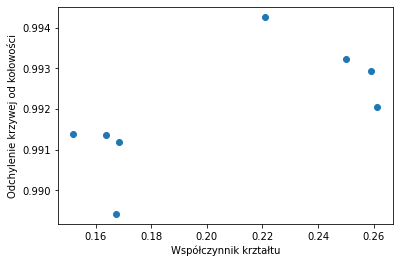

In [13]:
plt.scatter(c,d)
plt.xlabel('Współczynnik krztałtu')
plt.ylabel('Odchylenie krzywej od kołowości')

### Grupowanie:

### K-średnich:

In [19]:
start = time.time()
kmeans = KMeans(n_clusters=2)
kmeans.fit(b)
y_kmeans = kmeans.predict(b)
end = time.time()
czas = end - start
print("Czas działania algortmu : {czas}".format(czas = czas))

Czas działania algortmu : 0.025218725204467773


Liczba elementów przydzielonych do danych klastrów:

In [20]:
for i in range(0,2):
  row = np.where(y_kmeans==i)[0] 
  num = row.shape[0] 
  
  print("cluster "+str(i))
  print(str(num)+" elements")

cluster 0
4 elements
cluster 1
4 elements


Zakalsyfikowanie elemetów:

In [21]:
y_kmeans

array([0, 0, 1, 1, 0, 1, 0, 1], dtype=int32)

Tworzenie interaktywnego wykresu:


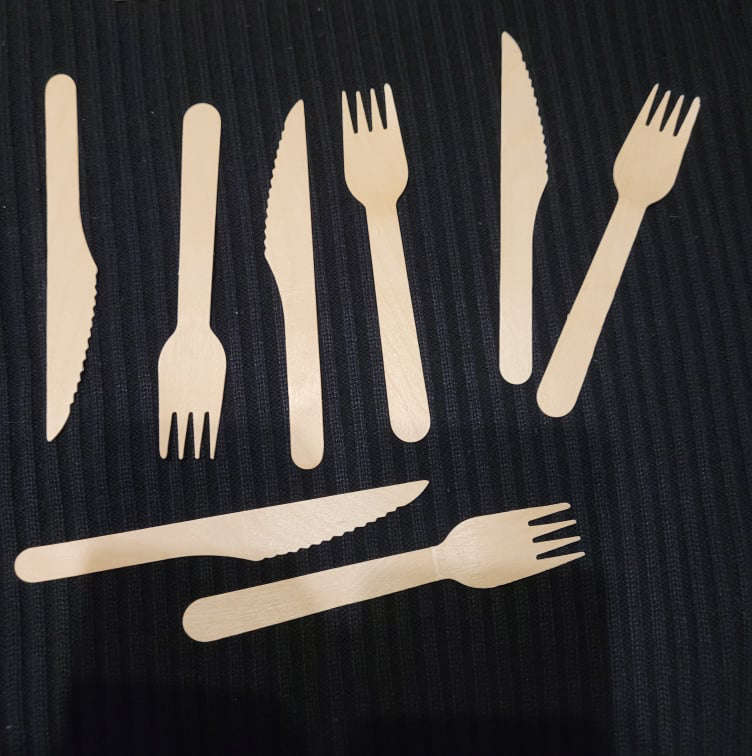

In [22]:
fig = px.imshow(img)
fig.update_traces(hoverinfo='skip') # hover is only for label info

props = measure.regionprops(img_labeled)
type = ['nóż','widelec']


for i in range(len(indeksy_obiektow)):
  label_i = props[indeksy_obiektow[i]].label
  contour = measure.find_contours(img_labeled == label_i, 0.5)[0]
  y, x = contour.T
  hoverinfo = ''
  hoverinfo += f'<b>{"typ"}: {type[y_kmeans[i]]}</b><br>'


  if y_kmeans[i] == 0:
    fig.add_trace(go.Scatter(
          x=x, y=y, name=indeksy_obiektow[i],
          mode='none', fill='toself',fillcolor = 'seashell', showlegend=False, hovertemplate=hoverinfo, hoveron='points+fills'))
  else:
    fig.add_trace(go.Scatter(
          x=x, y=y, name=indeksy_obiektow[i],
          mode='none', fill='toself',fillcolor = 'magenta', showlegend=False, hovertemplate=hoverinfo, hoveron='points+fills'))

plotly.io.show(fig)

Text(0, 0.5, 'Odchylenie krzywej od kołowości')

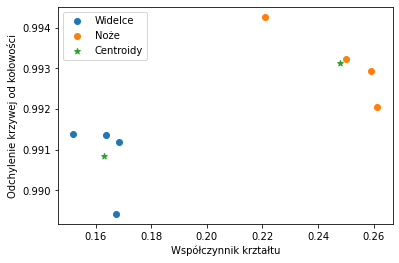

In [23]:
e=[]
for i in (2,3,5,7):
  e.append(c[i])

f=[]
for i in (2,3,5,7):
  f.append(d[i])

g=[]
for i in (0,1,4,6):
  g.append(c[i])

h=[]
for i in (0,1,4,6):
  h.append(d[i])

plt.scatter(e,f)
plt.scatter(g,h)
plt.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1],marker='*')
plt.legend(['Widelce', 'Noże', 'Centroidy'])
plt.xlabel('Współczynnik krztałtu')
plt.ylabel('Odchylenie krzywej od kołowości')

Klasyfikacja metodą k-średnich z 2 skupieniami przebiegła pomyślnie.

#### K-średnich (z błędnie podaną liczbą klastrów)

Sprawdzenie jak zadziała metoda k-średnich dla liczby skupień = 4. 

Pytanie badawcze: Czy do jakiegoś skupienia trafi i nóż i widelec?

In [24]:
start = time.time()
kmeans = KMeans(n_clusters=4) # liczba klastrów
kmeans.fit(b)
y_kmeans = kmeans.predict(b)
end = time.time()
czas = end - start
print("Czas działania algortmu : {czas}".format(czas = czas))

Czas działania algortmu : 0.02109980583190918


Liczba elementów w skupieniach:

In [26]:
for i in range(0,4):
  row = np.where(y_kmeans==i)[0] 
  num = row.shape[0]       
  
  print("Skupienie nr"+str(i))
  print(str(num)+" elementy")

Skupienie nr0
3 elementy
Skupienie nr1
1 elementy
Skupienie nr2
1 elementy
Skupienie nr3
3 elementy


Przypisanie elementów do skupień:

In [27]:
y_kmeans

array([0, 0, 3, 3, 0, 3, 2, 1], dtype=int32)

Stworzenie interaktywnego wykresu:


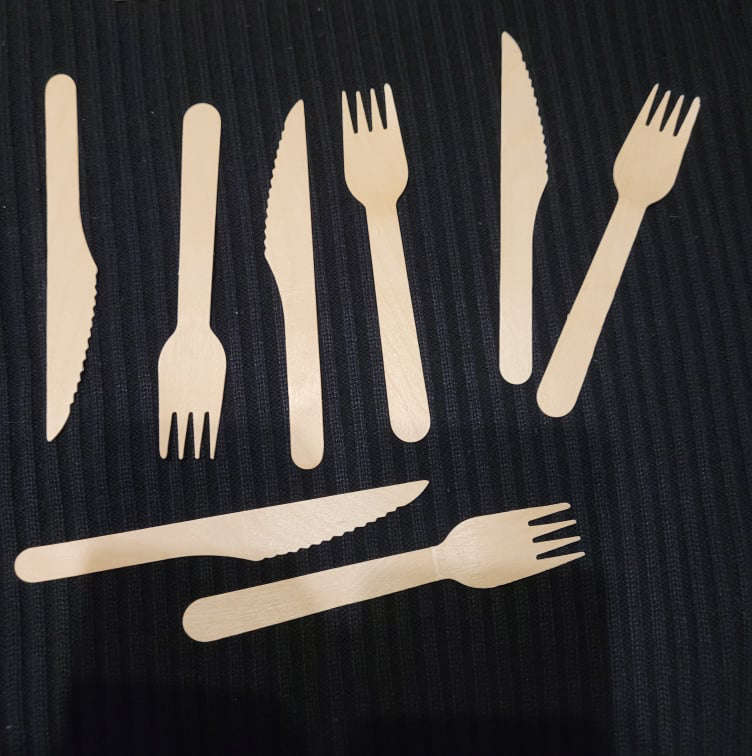

In [28]:
fig = px.imshow(img)
fig.update_traces(hoverinfo='skip')

props = measure.regionprops(img_labeled)
type = ['klaster 1', 'klaster 2', 'klaster 3','klaster 4']


for i in range(len(indeksy_obiektow)):
  label_i = props[indeksy_obiektow[i]].label
  contour = measure.find_contours(img_labeled == label_i, 0.5)[0]
  y, x = contour.T
  hoverinfo = ''
  hoverinfo += f'<b>{"typ"}: {type[y_kmeans[i]]}</b><br>'


  if y_kmeans[i] == 0:
    fig.add_trace(go.Scatter(
          x=x, y=y, name=indeksy_obiektow[i],
          mode='none', fill='toself',fillcolor = 'seashell', showlegend=False, hovertemplate=hoverinfo, hoveron='points+fills'))
  elif y_kmeans[i] == 1:
    fig.add_trace(go.Scatter(
          x=x, y=y, name=indeksy_obiektow[i],
          mode='none', fill='toself',fillcolor = 'yellow', showlegend=False, hovertemplate=hoverinfo, hoveron='points+fills'))
  
  elif y_kmeans[i] == 2:
    fig.add_trace(go.Scatter(
          x=x, y=y, name=indeksy_obiektow[i],
          mode='none', fill='toself',fillcolor = 'green', showlegend=False, hovertemplate=hoverinfo, hoveron='points+fills'))
  
  else:
    fig.add_trace(go.Scatter(
          x=x, y=y, name=indeksy_obiektow[i],
          mode='none', fill='toself',fillcolor = 'magenta', showlegend=False, hovertemplate=hoverinfo, hoveron='points+fills'))


  
plotly.io.show(fig)

Wykres dla prawidłowych przypisań elementów i centrodiów dla modelu z czterema skupieniami:

Text(0.5, 1.0, 'Wykres dla prawidłowych przypisań elementów i centrodiów dla modelu z czterema skupieniami')

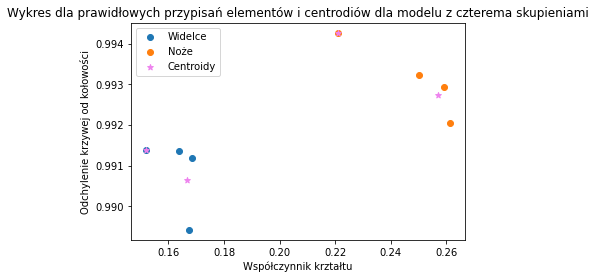

In [32]:
e=[]
for i in (2,3,5,7):
  e.append(c[i])

f=[]
for i in (2,3,5,7):
  f.append(d[i])

g=[]
for i in (0,1,4,6):
  g.append(c[i])

h=[]
for i in (0,1,4,6):
  h.append(d[i])

plt.scatter(e,f)
plt.scatter(g,h)
plt.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1],marker='*', color="violet")
plt.legend(['Widelce', 'Noże', 'Centroidy'])
plt.xlabel('Współczynnik krztałtu')
plt.ylabel('Odchylenie krzywej od kołowości')
plt.title('Wykres dla prawidłowych przypisań elementów i centrodiów dla modelu z czterema skupieniami')

Do żadnego skupienia nie dołączyły zarówno noże i widelce.

### Metoda Warda

In [45]:
start = time.time()
model_Warda = linkage(X, method = 'ward', metric = 'euclidean')
end = time.time()
czas = end - start
print("Czas działania algortmu : {czas}".format(czas = czas))

Czas działania algortmu : 0.0005860328674316406


Przypisanie elementów do skupień:

In [46]:
fcluster(model_Warda, 2, criterion='maxclust')

array([2, 2, 1, 1, 2, 1, 2, 1], dtype=int32)

Dendogram:

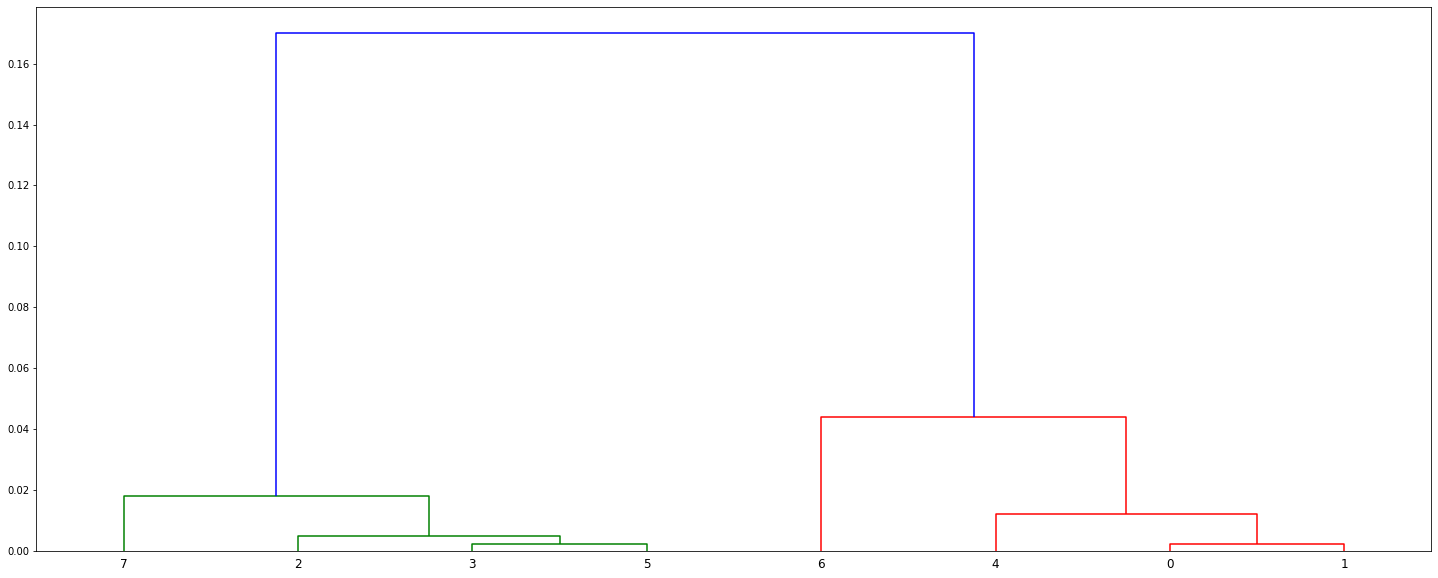

In [44]:
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(model_Warda)
plt.show()

Klasyfikacja metodą Warda przebiegła prawidłowo (odcinąjąc na dwóch skupieniach). Czas trwania alogrytmu był znacznie krótszy niż metodą k-średnich.

### Metoda pojedyńczych wiązań:

In [71]:
start = time.time()
model_pojedyńczych = linkage(X, method = 'single', metric = 'cityblock')
end = time.time()
czas = end - start
print("Czas działania algortmu : {czas}".format(czas = czas))

Czas działania algortmu : 0.0005321502685546875


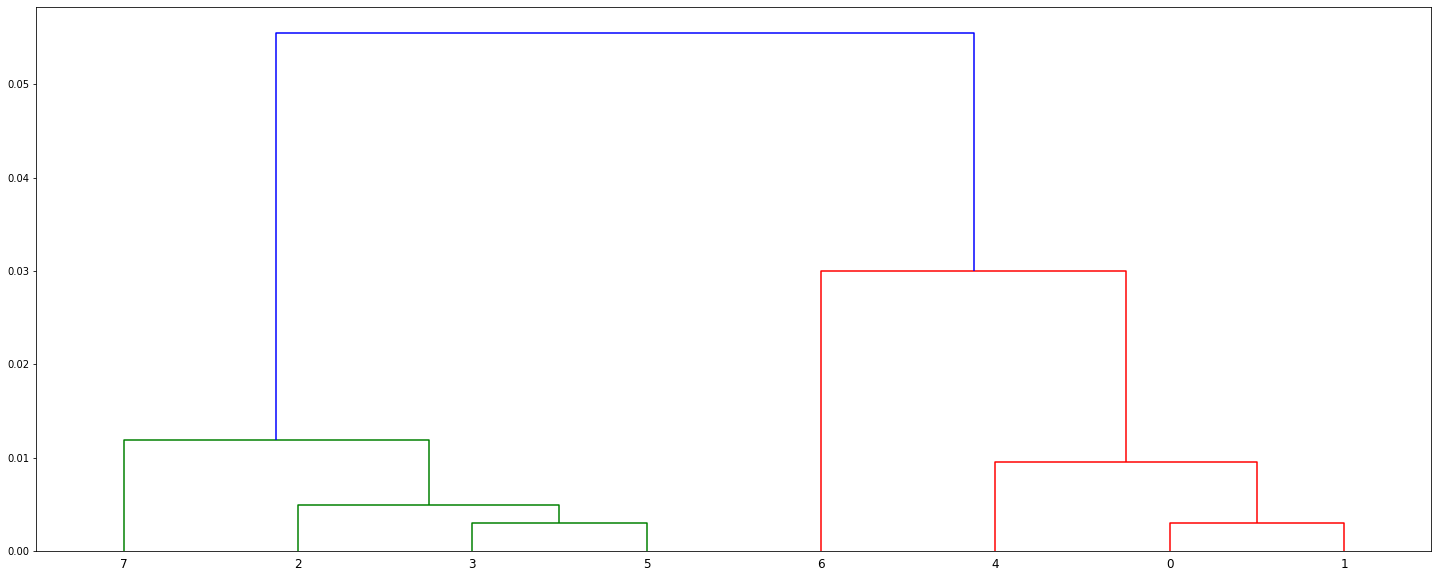

In [72]:
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(model_pojedyńczych)
plt.show()

Klasyfikacja metodą pojedyńzcych wiązań, przebiegła pomyślnie. Czas trwania algorytmu podobny do klasyfikacji metodą Warda.

### Regresja logistyczna:

W przypadku podziału na dwie klasy używana jest funkcja sigmoidalna i BinaryCrossentropy.

In [58]:
from keras import metrics
from keras.models import Sequential
from keras.layers import Dense
model = Sequential()
N=X.shape[1]
model.add(Dense(1, activation='sigmoid', input_dim = N))
model.compile(optimizer='adadelta', loss='mean_squared_error', metrics=['binary_accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 1)                 3         
                                                                 
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


In [63]:
y=np.array([0,1,0,0,1,0,1,1])
history=model.fit(X,y,shuffle=True,epochs=10, batch_size=10)

Epoch 1/10
1/1 [==============================] - 0s 16ms/step - loss: 0.2578 - binary_accuracy: 0.5000
Epoch 2/10
1/1 [==============================] - 0s 11ms/step - loss: 0.2578 - binary_accuracy: 0.5000
Epoch 3/10
1/1 [==============================] - 0s 12ms/step - loss: 0.2578 - binary_accuracy: 0.5000
Epoch 4/10
1/1 [==============================] - 0s 12ms/step - loss: 0.2578 - binary_accuracy: 0.5000
Epoch 5/10
1/1 [==============================] - 0s 17ms/step - loss: 0.2578 - binary_accuracy: 0.5000
Epoch 6/10
1/1 [==============================] - 0s 14ms/step - loss: 0.2578 - binary_accuracy: 0.5000
Epoch 7/10
1/1 [==============================] - 0s 18ms/step - loss: 0.2578 - binary_accuracy: 0.5000
Epoch 8/10
1/1 [==============================] - 0s 12ms/step - loss: 0.2578 - binary_accuracy: 0.5000
Epoch 9/10
1/1 [==============================] - 0s 13ms/step - loss: 0.2578 - binary_accuracy: 0.5000
Epoch 10/10
1/1 [==============================] - 0s 14ms/step 

In [60]:
a,b=model.layers[0].weights[0]
w=model.layers[0].weights[1]
print("F = "+str(a.numpy()[0])+"*X1 + "+str(b.numpy()[0])+"*X2 + "+str(w.numpy()[0]))

F = -1.3321276*X1 + 0.48014623*X2 + -0.00024121092


In [61]:
_, accuracy = model.evaluate(X,y)
print('Accuracy:%.2f'%(accuracy*100))

1/1 [==============================] - 0s 157ms/step - loss: 0.2578 - binary_accuracy: 0.5000
Accuracy:50.00


In [62]:
model.predict(X)

array([[0.53274715],
       [0.53192973],
       [0.5640367 ],
       [0.5624532 ],
       [0.53584933],
       [0.5626386 ],
       [0.5455664 ],
       [0.5679288 ]], dtype=float32)